In [ ]:
from xml.sax.handler import feature_namespace_prefixes

from babel.messages.frontend import SetupError

Setup

In [18]:
import iris
import pandas as pd

host = "localhost"
# this is the superserver port
port = 32782
namespace = "FHIRSERVER"
user = "_SYSTEM"
password = "SYS"

conn = iris.connect(
    hostname=host,
    port=port,
    namespace=namespace,
    username=user,
    password=password
)

# create a cursor
cursor = conn.cursor()
cursor

The likelyhood of getting diabetes is altered by a number of factors including:

- Age
- Ethnicity
- Family History
- Weight
- Physical Inactivity
- Genetics
- Other Conditions: High blood pressure, high cholesterol, and heart disease increase the risk

To explore this data I will be using synthetic patients records from [Synthea](https://synthetichealth.github.io/synthea/) using a community version of a FHIR enabled Data Platform from Intersystems called IRIS [Intersystems Open Exchange - iris-fhir-template](https://openexchange.intersystems.com/package/iris-fhir-template).
These examples are based on US population demographics and will also use a mix of LOINC and SNOMED coding, so codes used are likely to differ from UK based systems which predominantly use SNOMED CT UK Edition.

162864005 	Body mass index 30+ - obesity
408512008   Body mass index 40+ - severely obese

In [4]:


sql = """
      select patient._id, patient.KEY, DATEDIFF('year',birthdate,$HOROLOG) as AGE,
             gender,
             case gender
                 when 'male' then 1
                 when 'female' then 2
                 when 'other' then 0
                 else 9
                 end as genderUK,
             IFNULL(diabetes._id,0,1) as TYPE2DIABETES,
             IFNULL(hypertension._id,0,1) as HYPERTENSION,
             IFNULL(obese._id,0,1) as OBESE,
             IFNULL(veryobese._id,0,1) as VERY_OBESE,
             IFNULL(diabetes._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(diabetes.onsetDateStart,'YYYY-MM-DD'))) as TYPE2DIABETES_AGE,
             IFNULL(hypertension._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(hypertension.onsetDateStart,'YYYY-MM-DD'))) as HYPERTENSION_AGE,
             IFNULL(obese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(obese.onsetDateStart,'YYYY-MM-DD'))) as OBESE_AGE,
             IFNULL(veryobese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(veryobese.onsetDateStart,'YYYY-MM-DD'))) as VERY_OBESE_AGE
      from HSFHIR_X0001_S.Patient patient
          join HSFHIR_X0001_R.Rsrc resource where resource.ResourceType = 'Patient' and resource.Key = patient.Key
               left outer join HSFHIR_X0001_S.Condition diabetes on patient.Key = diabetes.patient and diabetes.code [ '44054006'
               left outer join HSFHIR_X0001_S.Condition hypertension on patient.Key = hypertension.patient and hypertension.code [ '59621000'
               left outer join HSFHIR_X0001_S.Condition obese on patient.Key = obese.patient and obese.code [ '162864005'
               left outer join HSFHIR_X0001_S.Condition veryobese on patient.Key = veryobese.patient and veryobese.code [ '408512008'
      """

cursor.execute(sql)
data = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(data, columns=column_names)
pd.set_option('future.no_silent_downcasting', True)
df

,_id,Key,AGE,gender,genderUK,TYPE2DIABETES,HYPERTENSION,OBESE,VERY_OBESE,TYPE2DIABETES_AGE,HYPERTENSION_AGE,OBESE_AGE,VERY_OBESE_AGE
0,4,Patient/4,50,male,1,0,1,1,0,NaN,18.0,40.0,NaN
1,2,Patient/2,71,male,1,0,0,1,0,NaN,NaN,37.0,NaN
2,3,Patient/3,16,female,2,0,0,0,0,NaN,NaN,NaN,NaN
3,5,Patient/5,80,female,2,0,0,1,0,NaN,NaN,35.0,NaN
4,6,Patient/6,80,female,2,0,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382,1195651,Patient/1195651,20,female,2,0,0,0,0,NaN,NaN,NaN,NaN
2383,1195696,Patient/1195696,31,female,2,0,0,0,0,NaN,NaN,NaN,NaN
2384,1195942,Patient/1195942,75,female,2,0,0,0,0,NaN,NaN,NaN,NaN
2385,1196467,Patient/1196467,82,male,1,0,0,1,0,NaN,NaN,28.0,NaN


In the preceeding display we can the AGE results have are being skewed by patients who don't have the condition. What we need to do is assign these patients a 'none' value.

Note: using null in the SQL query has automated this. So next step isn't necessary

In [6]:
df['TYPE2DIABETES_AGE'] = df['TYPE2DIABETES_AGE'].replace(-1, pd.NA).fillna(0).astype(int)
df['HYPERTENSION_AGE'] = df['HYPERTENSION_AGE'].replace(-1, pd.NA).fillna(0).astype(int)
df

,_id,Key,AGE,gender,genderUK,TYPE2DIABETES,HYPERTENSION,OBESE,VERY_OBESE,TYPE2DIABETES_AGE,HYPERTENSION_AGE,OBESE_AGE,VERY_OBESE_AGE
0,4,Patient/4,50,male,1,0,1,1,0,0,18,40.0,NaN
1,2,Patient/2,71,male,1,0,0,1,0,0,0,37.0,NaN
2,3,Patient/3,16,female,2,0,0,0,0,0,0,NaN,NaN
3,5,Patient/5,80,female,2,0,0,1,0,0,0,35.0,NaN
4,6,Patient/6,80,female,2,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382,1195651,Patient/1195651,20,female,2,0,0,0,0,0,0,NaN,NaN
2383,1195696,Patient/1195696,31,female,2,0,0,0,0,0,0,NaN,NaN
2384,1195942,Patient/1195942,75,female,2,0,0,0,0,0,0,NaN,NaN
2385,1196467,Patient/1196467,82,male,1,0,0,1,0,0,0,28.0,NaN


Some of the values in the last section are wrong or nonsense, I will correct that later.

The mean AGE values are correct. This is visible in the diagram below.

gender
female    Axes(0.125,0.11;0.775x0.77)
male      Axes(0.125,0.11;0.775x0.77)
Name: AGE, dtype: object

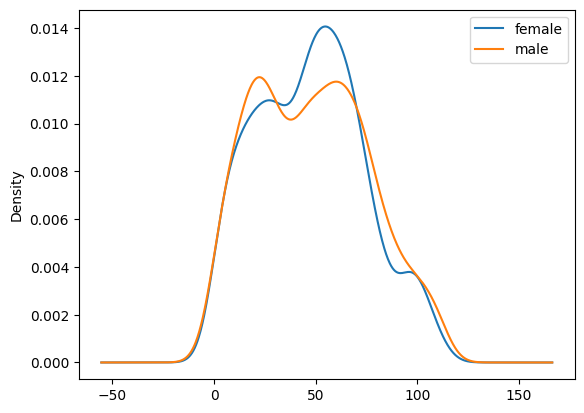

In [31]:
df.groupby('gender').AGE.plot(kind='kde',legend=True)

TYPE2DIABETES

,gender,TYPE2DIABETES_AGE,TYPE2DIABETES,_id,Key
21,male,21.0,1,2429,Patient/2429
41,male,28.0,1,10816,Patient/10816
42,female,19.0,1,10897,Patient/10897
43,female,40.0,1,11146,Patient/11146
50,male,31.0,1,13862,Patient/13862
...,...,...,...,...,...
2318,male,31.0,1,1159054,Patient/1159054
2347,female,31.0,1,1174155,Patient/1174155
2351,male,37.0,1,1176237,Patient/1176237
2359,male,31.0,1,1182563,Patient/1182563


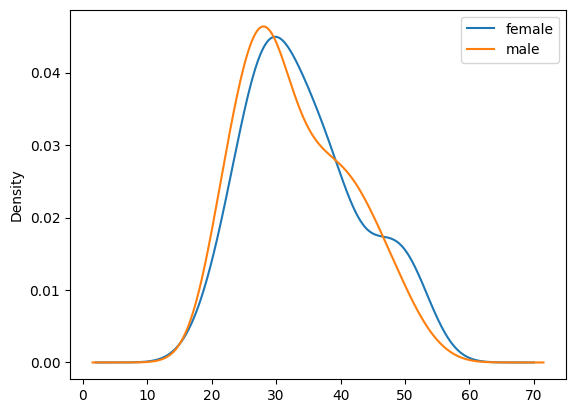

In [30]:
dfDiabetes = df[['gender','TYPE2DIABETES_AGE','TYPE2DIABETES','_id','Key']].query('TYPE2DIABETES == 1')
dfDiabetes.groupby('gender').TYPE2DIABETES_AGE.plot(kind='kde',legend=True)

dfDiabetes

,gender,OBESE_AGE,OBESE,_id,Key
0,male,37.0,1,2,Patient/2
2,male,40.0,1,4,Patient/4
3,female,35.0,1,5,Patient/5
9,male,16.0,1,2372,Patient/2372
10,female,44.0,1,2373,Patient/2373
...,...,...,...,...,...
2373,male,20.0,1,1189425,Patient/1189425
2374,male,52.0,1,1191361,Patient/1191361
2381,female,29.0,1,1194893,Patient/1194893
2382,female,28.0,1,1195265,Patient/1195265


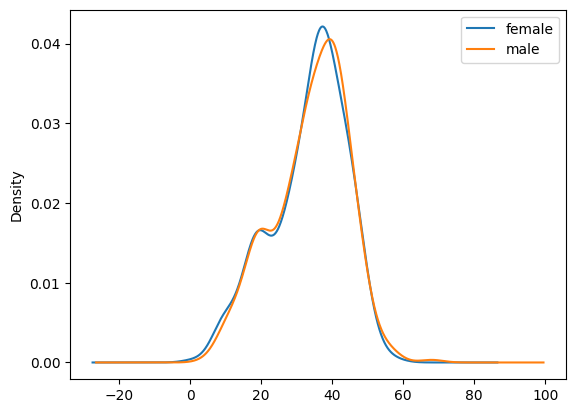

In [29]:
dfDiabetes = df[['gender','OBESE_AGE','OBESE','_id','Key']].query('OBESE == 1')
dfDiabetes.groupby('gender').OBESE_AGE.plot(kind='kde',legend=True)

dfDiabetes

We are missing ethnic, race and birth sex from our dataset. This includes a concept in FHIR called FHIRPath and this is demonstrated in another workbook.


In [19]:
sql = """
      select patient._id, patient.KEY, DATEDIFF('year',birthdate,$HOROLOG) as AGE,
             gender,
             case gender
                 when 'male' then 1
                 when 'female' then 2
                 when 'other' then 0
                 else 9
                 end as genderUK,
             IFNULL(diabetes._id,0,1) as TYPE2DIABETES,
             IFNULL(hypertension._id,0,1) as HYPERTENSION,
             IFNULL(obese._id,0,1) as OBESE,
             IFNULL(veryobese._id,0,1) as VERY_OBESE,
             IFNULL(diabetes._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(diabetes.onsetDateStart,'YYYY-MM-DD'))) as TYPE2DIABETES_AGE,
             IFNULL(hypertension._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(hypertension.onsetDateStart,'YYYY-MM-DD'))) as HYPERTENSION_AGE,
             IFNULL(obese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(obese.onsetDateStart,'YYYY-MM-DD'))) as OBESE_AGE,
             IFNULL(veryobese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(veryobese.onsetDateStart,'YYYY-MM-DD'))) as VERY_OBESE_AGE
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-race'').extension(''ombCategory'').valueCoding.display','Patient') Race
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-race'').extension(''ombCategory'').valueCoding.code','Patient') RaceCode
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-ethnicity'').extension(''ombCategory'').valueCoding.display','Patient') Ethnic
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-ethnicity'').extension(''ombCategory'').valueCoding.code','Patient') EthnicCode
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-birthsex'').valueCode', 'Patient') BirthSex

      from HSFHIR_X0001_S.Patient patient
               join HSFHIR_X0001_R.Rsrc resource on resource.ResourceType = 'Patient' and resource.Key = patient.Key
               left outer join HSFHIR_X0001_S.Condition diabetes on patient.Key = diabetes.patient and diabetes.code [ '44054006'
               left outer join HSFHIR_X0001_S.Condition hypertension on patient.Key = hypertension.patient and hypertension.code [ '59621000'
               left outer join HSFHIR_X0001_S.Condition obese on patient.Key = obese.patient and obese.code [ '162864005'
               left outer join HSFHIR_X0001_S.Condition veryobese on patient.Key = veryobese.patient and veryobese.code [ '408512008'
      """

cursor.execute(sql)
data = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(data, columns=column_names)
pd.set_option('future.no_silent_downcasting', True)
df

,_id,Key,AGE,gender,genderUK,TYPE2DIABETES,HYPERTENSION,OBESE,VERY_OBESE,TYPE2DIABETES_AGE,HYPERTENSION_AGE,OBESE_AGE,VERY_OBESE_AGE,Race,RaceCode,Ethnic,EthnicCode,BirthSex
0,2,Patient/2,71,male,1,0,0,1,0,NaN,NaN,37.0,NaN,White,2106-3,Not Hispanic or Latino,2186-5,M
1,3,Patient/3,16,female,2,0,0,0,0,NaN,NaN,NaN,NaN,White,2106-3,Not Hispanic or Latino,2186-5,F
2,4,Patient/4,50,male,1,0,1,1,0,NaN,18.0,40.0,NaN,White,2106-3,Not Hispanic or Latino,2186-5,M
3,5,Patient/5,80,female,2,0,0,1,0,NaN,NaN,35.0,NaN,Asian,2028-9,Not Hispanic or Latino,2186-5,F
4,6,Patient/6,80,female,2,0,0,0,0,NaN,NaN,NaN,NaN,Asian,2028-9,Not Hispanic or Latino,2186-5,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382,1195265,Patient/1195265,33,female,2,1,0,1,0,31.0,NaN,28.0,NaN,Asian,2028-9,Not Hispanic or Latino,2186-5,F
2383,1195651,Patient/1195651,20,female,2,0,0,0,0,NaN,NaN,NaN,NaN,White,2106-3,Not Hispanic or Latino,2186-5,F
2384,1195696,Patient/1195696,31,female,2,0,0,0,0,NaN,NaN,NaN,NaN,White,2106-3,Not Hispanic or Latino,2186-5,F
2385,1195942,Patient/1195942,75,female,2,0,0,0,0,NaN,NaN,NaN,NaN,Black or African American,2054-5,Not Hispanic or Latino,2186-5,F


In [39]:
dfObesity = df[['Ethnic','Race','gender','genderUK','OBESE_AGE','OBESE','_id','Key']].query('OBESE == 1')

dfObesity

,Ethnic,Race,gender,genderUK,OBESE_AGE,OBESE,_id,Key
0,Not Hispanic or Latino,White,male,1,37.0,1,2,Patient/2
2,Not Hispanic or Latino,White,male,1,40.0,1,4,Patient/4
3,Not Hispanic or Latino,Asian,female,2,35.0,1,5,Patient/5
9,Hispanic or Latino,White,male,1,16.0,1,2372,Patient/2372
10,Not Hispanic or Latino,White,female,2,44.0,1,2373,Patient/2373
...,...,...,...,...,...,...,...,...
2373,Not Hispanic or Latino,White,male,1,20.0,1,1189425,Patient/1189425
2374,Not Hispanic or Latino,White,male,1,52.0,1,1191361,Patient/1191361
2381,Not Hispanic or Latino,White,female,2,29.0,1,1194893,Patient/1194893
2382,Not Hispanic or Latino,Asian,female,2,28.0,1,1195265,Patient/1195265


Ethnic
Hispanic or Latino        Axes(0.125,0.11;0.775x0.77)
Not Hispanic or Latino    Axes(0.125,0.11;0.775x0.77)
Name: OBESE_AGE, dtype: object

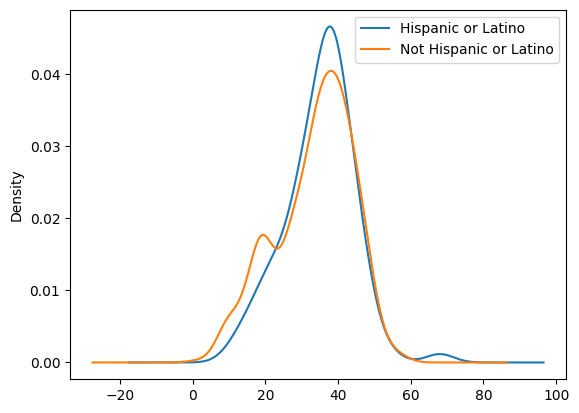

In [33]:
dfObesity.groupby('Ethnic').OBESE_AGE.plot(kind='kde',legend=True)


Race
American Indian or Alaska Native    Axes(0.125,0.11;0.775x0.77)
Asian                               Axes(0.125,0.11;0.775x0.77)
Black or African American           Axes(0.125,0.11;0.775x0.77)
White                               Axes(0.125,0.11;0.775x0.77)
Name: OBESE_AGE, dtype: object

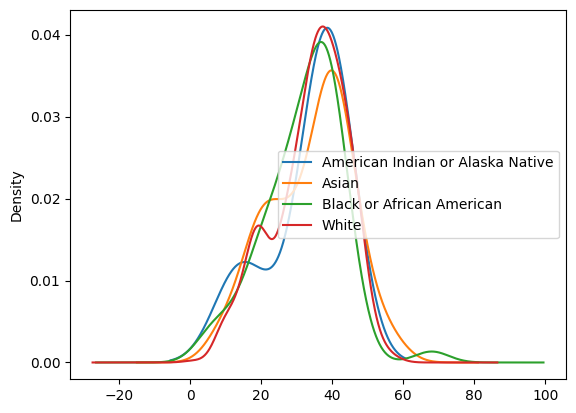

In [32]:
dfObesity.groupby('Race').OBESE_AGE.plot(kind='kde',legend=True)


Race
American Indian or Alaska Native    Axes(0.125,0.11;0.775x0.77)
Asian                               Axes(0.125,0.11;0.775x0.77)
Black or African American           Axes(0.125,0.11;0.775x0.77)
White                               Axes(0.125,0.11;0.775x0.77)
Name: OBESE_AGE, dtype: object

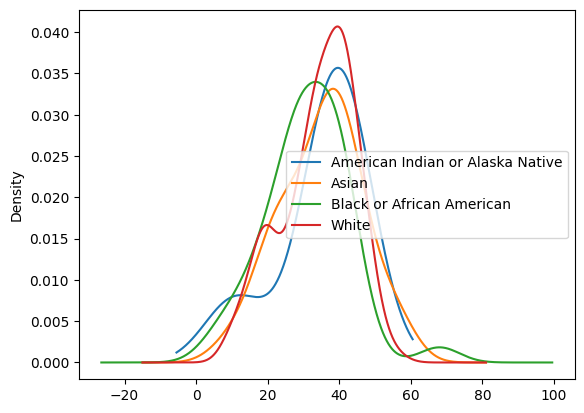

In [40]:
dfObesity.query('genderUK == 1').groupby('Race').OBESE_AGE.plot(kind='kde',legend=True)

Race
American Indian or Alaska Native    Axes(0.125,0.11;0.775x0.77)
Asian                               Axes(0.125,0.11;0.775x0.77)
Black or African American           Axes(0.125,0.11;0.775x0.77)
White                               Axes(0.125,0.11;0.775x0.77)
Name: OBESE_AGE, dtype: object

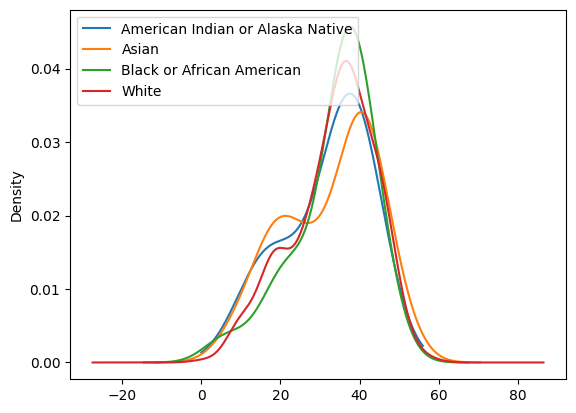

In [41]:
dfObesity.query('genderUK == 2').groupby('Race').OBESE_AGE.plot(kind='kde',legend=True)

In [42]:
dfDiabetes = df[['Ethnic','Race','gender','genderUK','TYPE2DIABETES_AGE','TYPE2DIABETES','_id','Key']].query('TYPE2DIABETES == 1')

Ethnic
Hispanic or Latino        Axes(0.125,0.11;0.775x0.77)
Not Hispanic or Latino    Axes(0.125,0.11;0.775x0.77)
Name: TYPE2DIABETES_AGE, dtype: object

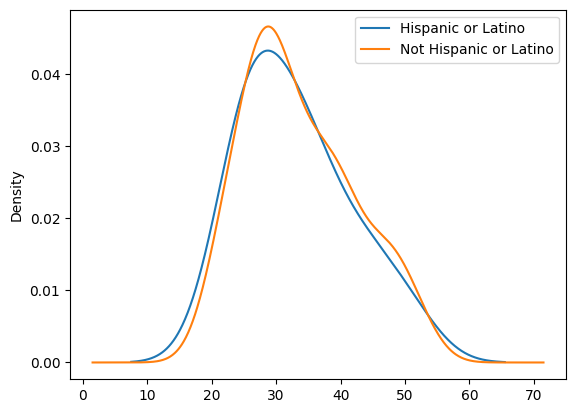

In [35]:
dfDiabetes.groupby('Ethnic').TYPE2DIABETES_AGE.plot(kind='kde',legend=True)

Race
American Indian or Alaska Native    Axes(0.125,0.11;0.775x0.77)
Asian                               Axes(0.125,0.11;0.775x0.77)
Black or African American           Axes(0.125,0.11;0.775x0.77)
White                               Axes(0.125,0.11;0.775x0.77)
Name: TYPE2DIABETES_AGE, dtype: object

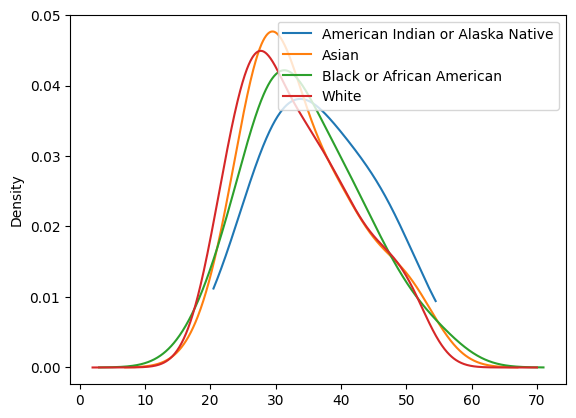

In [28]:
dfDiabetes.groupby('Race').TYPE2DIABETES_AGE.plot(kind='kde', legend=True)

Race
American Indian or Alaska Native    Axes(0.125,0.11;0.775x0.77)
Asian                               Axes(0.125,0.11;0.775x0.77)
Black or African American           Axes(0.125,0.11;0.775x0.77)
White                               Axes(0.125,0.11;0.775x0.77)
Name: TYPE2DIABETES_AGE, dtype: object

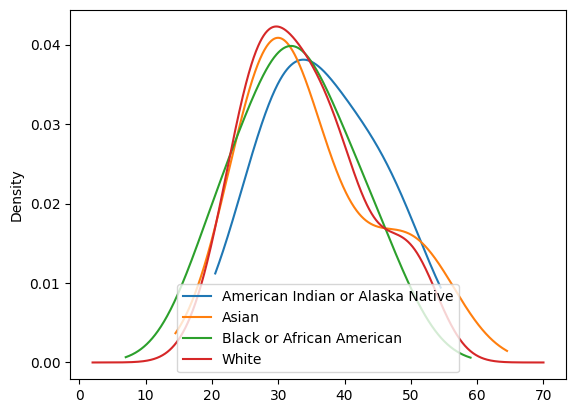

In [43]:
dfDiabetes.query('genderUK == 2').'groupby('Race').TYPE2DIABETES_AGE.plot(kind='kde', legend=True)

In [ ]:
df['First Season'] = np.where(df['First Season'] > 1990, 1, df['First Season'])

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

le_race = LabelEncoder()
le_gender = LabelEncoder()

X = df[['EthnicCode','RaceCode','genderUK','AGE', 'HYPERTENSION','OBESE','VERY_OBESE']].copy()

# Transform categorical columns
X['RaceCode'] = le_race.fit_transform(X['RaceCode'])
X['genderUKCode'] = le_gender.fit_transform(X['genderUK'])

Y = df.TYPE2DIABETES






The codes in EthnicCode represent Hispanic or Latino, or not. In the next section of code we change this to a 1 or 0.

In [65]:
import numpy as np
X['EthnicCode'] = np.where(X['EthnicCode'] == '2135-2', 1, 0)

X = X.rename(columns={'EthnicCode': 'LatinoHispanic'})

Run decision tree ML

In [66]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X,Y)

DecisionTreeClassifier(max_depth=5)

Render using dtreeviz

/Users/kevinmayfield/github/Phython/Play/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data

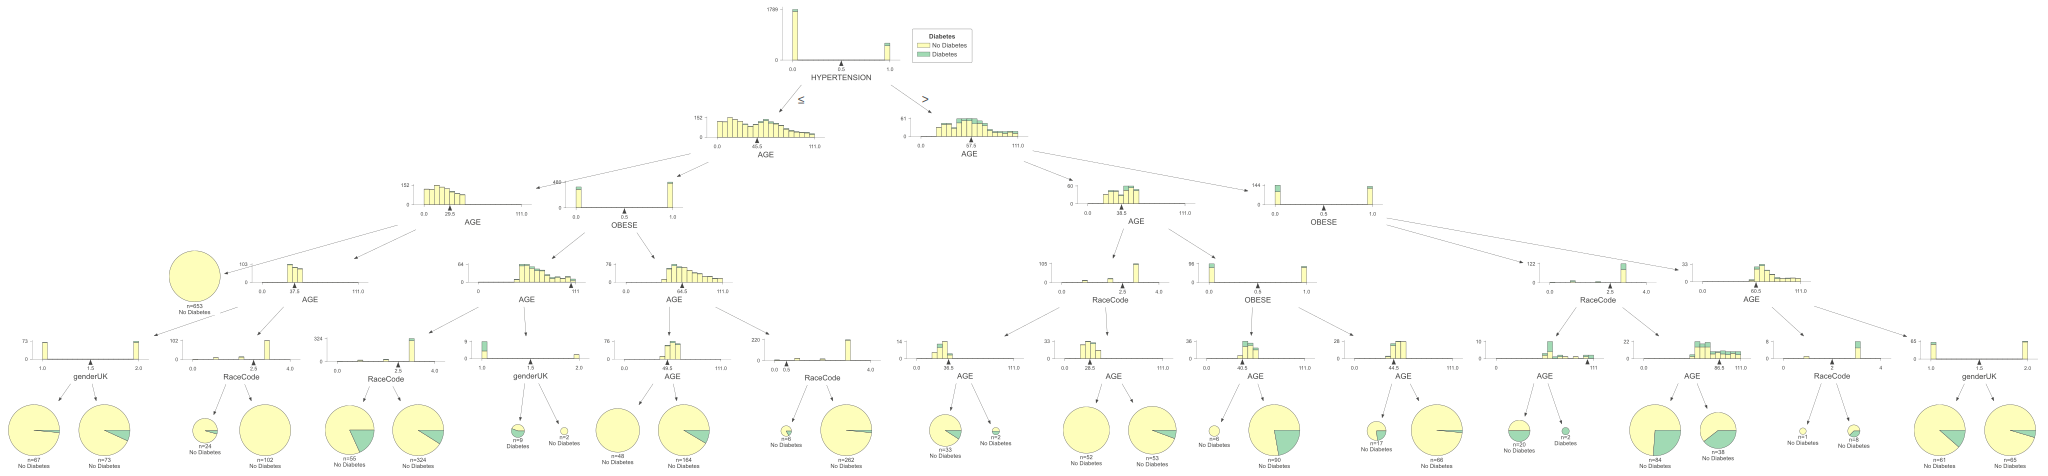

In [67]:
import dtreeviz

viz_model = dtreeviz.model(dt,
                           X_train=X, y_train=Y,
                           feature_names=X.columns,
                           target_name='Diabetes',
                           class_names=['No Diabetes', 'Diabetes'])

viz_model.view()

Maybe remove - this works in intelij and dtreeviz doesn't

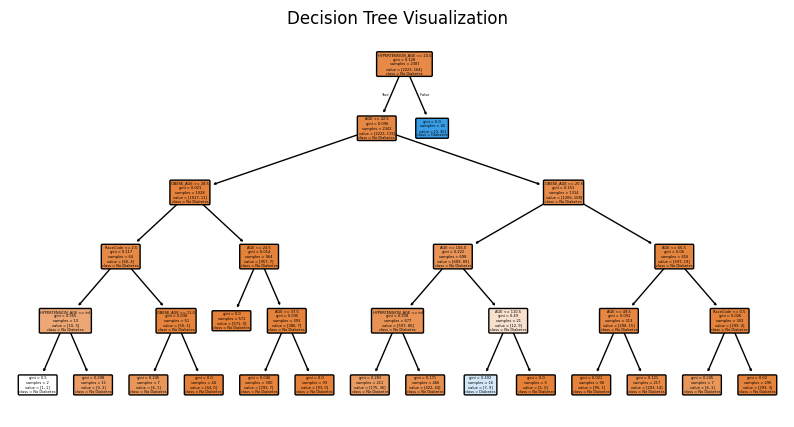

In [55]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assuming you have your decision tree model 'dt', and data X, Y
plt.figure(figsize=(10,5))
plot_tree(dt, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'],
          filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


In [17]:
conn.close()
conn

In [ ]:
cursor.isClosed()
cursor